In [1]:
pip install rasterio

Note: you may need to restart the kernel to use updated packages.


In [2]:
#import required libraries
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
from rasterio.plot import show
from skimage.feature import match_template
import numpy as np
from PIL import Image

In [3]:
#open point shapefile
pointData = gpd.read_file('Shp/Export_Output1.shp')
print('CRS of Point Data: ' + str(pointData.crs))

#open raster file
palmRaster = rasterio.open('Rst/result.tif')
print('CRS of Raster Data: ' + str(palmRaster.crs))
print('Number of Raster Bands: ' + str(palmRaster.count))
print('Interpretation of Raster Bands: ' + str(palmRaster.colorinterp))

CRS of Point Data: PROJCS["SLD99 / Sri Lanka Grid 1999",GEOGCS["SLD99",DATUM["Sri_Lanka_Datum_1999",SPHEROID["Everest 1830 (1937 Adjustment)",6377276.345,300.8017,AUTHORITY["EPSG","7015"]],AUTHORITY["EPSG","1053"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",7.00016975],PARAMETER["central_meridian",80.46181671],PARAMETER["scale_factor",0.9999238418],PARAMETER["false_easting",500000],PARAMETER["false_northing",500000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
CRS of Raster Data: LOCAL_CS["SLD99 / Sri Lanka Grid 1999",UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Number of Raster Bands: 4
Interpretation of Raster Bands: (<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>, <ColorInterp.alpha: 6>)


C:\Users\Pc\anaconda3\lib\site-packages\rasterio\plot.py:112: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


<AxesSubplot:>

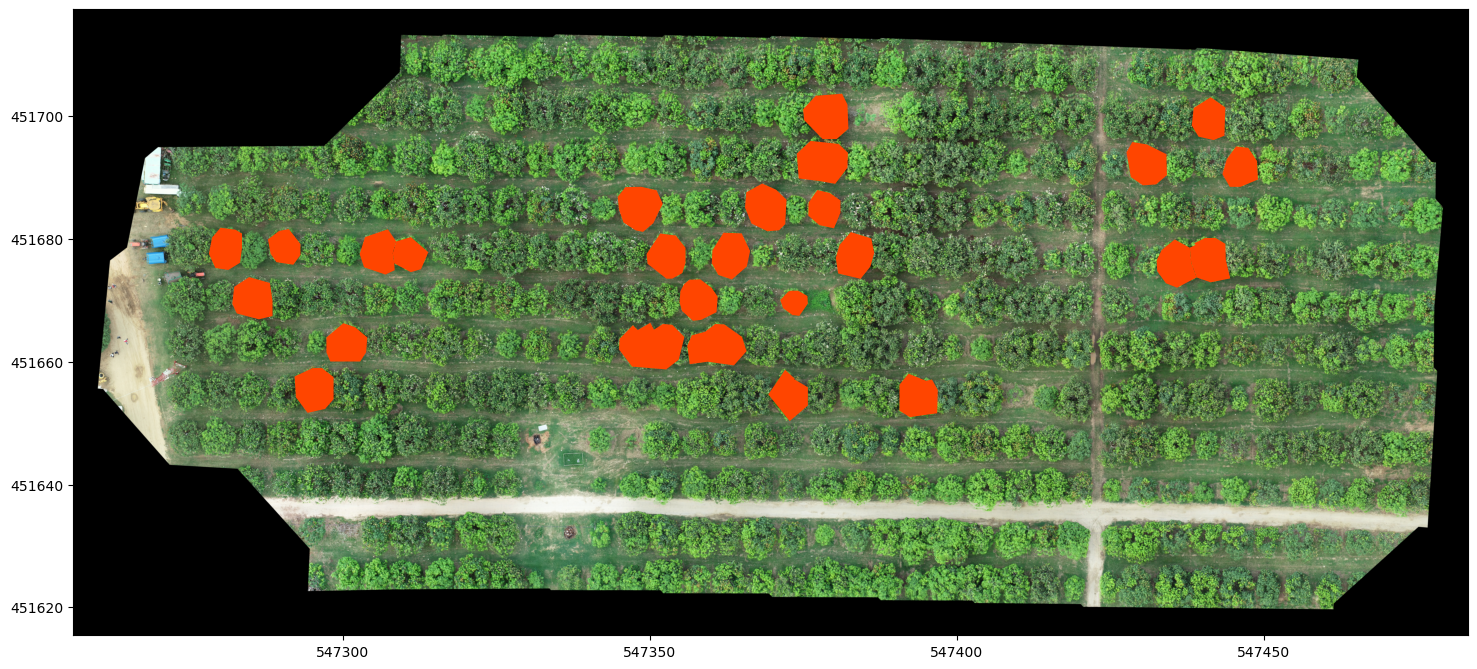

In [4]:
fig, ax = plt.subplots(figsize=(18,18))
pointData.plot(ax=ax, color='orangered', markersize=100)
show(palmRaster, ax=ax)

In [5]:
#selected band: green
greenBand = palmRaster.read(2)

In [6]:
# extract point value from raster
surveyRowCol = []
for index, values in pointData.iterrows():
    point = values['geometry'].centroid  # get centroid point of polygon
    x = point.xy[0][0]
    y = point.xy[1][0]
    row, col = palmRaster.index(x,y)
    print("Point N°:%d corresponds to row, col: %d, %d"%(index,row,col))
    surveyRowCol.append([row,col])


Point N°:0 corresponds to row, col: 1159, 11946
Point N°:1 corresponds to row, col: 1665, 12276
Point N°:2 corresponds to row, col: 2682, 11593
Point N°:3 corresponds to row, col: 2635, 11951
Point N°:4 corresponds to row, col: 1624, 11286
Point N°:5 corresponds to row, col: 1117, 7934
Point N°:6 corresponds to row, col: 1603, 7876
Point N°:7 corresponds to row, col: 2589, 8220
Point N°:8 corresponds to row, col: 4072, 8882
Point N°:9 corresponds to row, col: 4059, 7535
Point N°:10 corresponds to row, col: 2583, 6913
Point N°:11 corresponds to row, col: 2593, 6249
Point N°:12 corresponds to row, col: 2078, 5953
Point N°:13 corresponds to row, col: 2087, 7287
Point N°:14 corresponds to row, col: 2098, 7902
Point N°:15 corresponds to row, col: 3541, 6765
Point N°:16 corresponds to row, col: 3542, 6088
Point N°:17 corresponds to row, col: 3080, 7586
Point N°:18 corresponds to row, col: 3054, 6571
Point N°:19 corresponds to row, col: 2579, 3537
Point N°:20 corresponds to row, col: 2554, 32

In [7]:
# number of template images
print('Number of template images: %d'%len(surveyRowCol))
# define ratio of analysis
radio = 25

Number of template images: 26


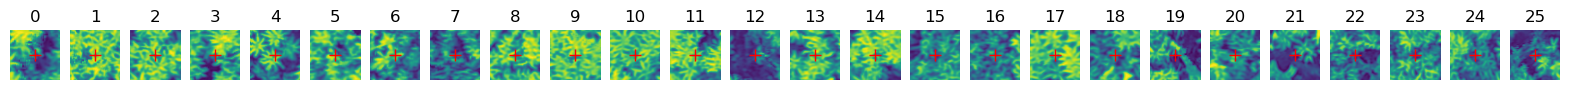

In [8]:
#show all the points of interest, please be careful to have a complete image, otherwise the model wont run
fig, ax = plt.subplots(1, len(surveyRowCol),figsize=(20,5))

for index, item in enumerate(surveyRowCol):
    row = item[0]
    col = item[1]
    ax[index].imshow(greenBand)
    ax[index].plot(col,row,color='red', linestyle='dashed', marker='+',
     markerfacecolor='blue', markersize=8)
    ax[index].set_xlim(col-radio,col+radio)
    ax[index].set_ylim(row-radio,row+radio)
    ax[index].axis('off')
    ax[index].set_title(index)


C:\Users\Pc\AppData\Local\Temp\ipykernel_4220\587168534.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))


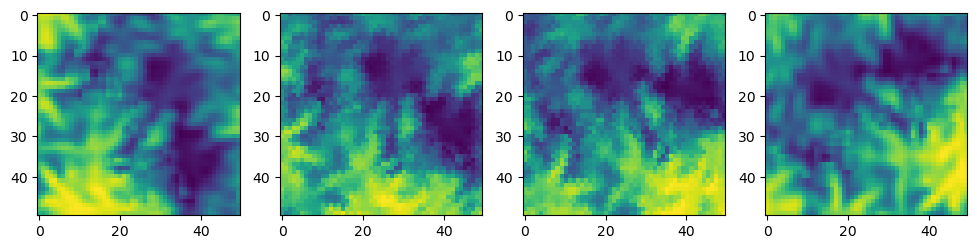

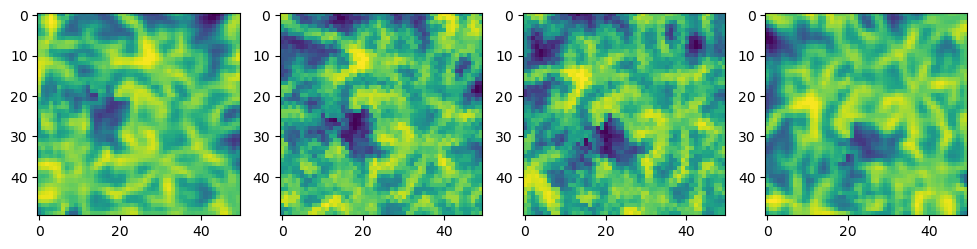

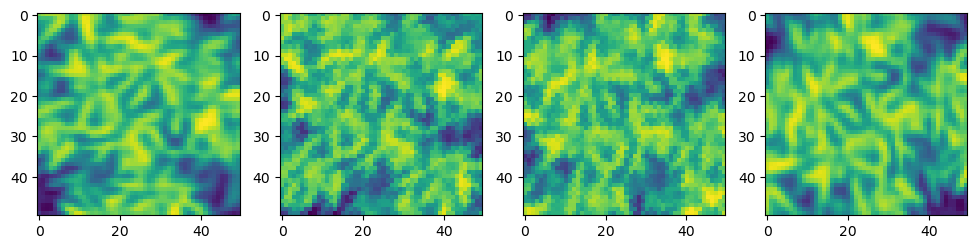

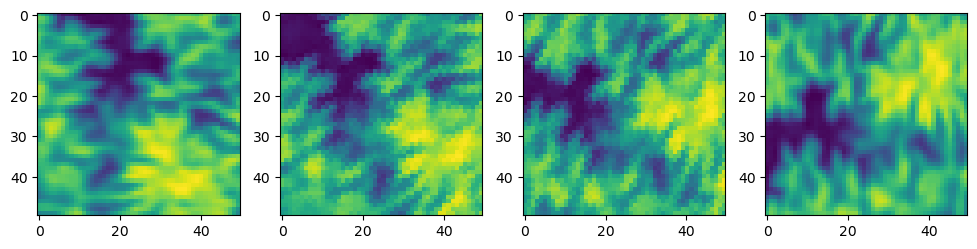

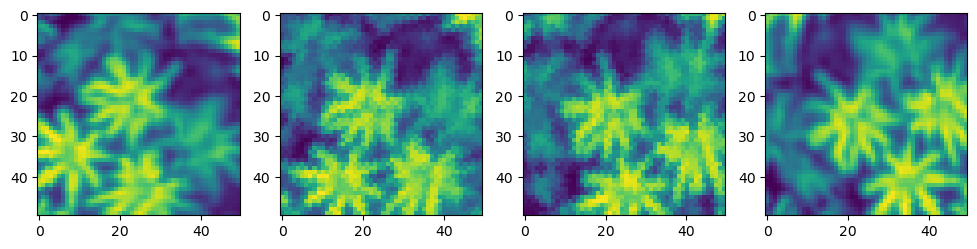

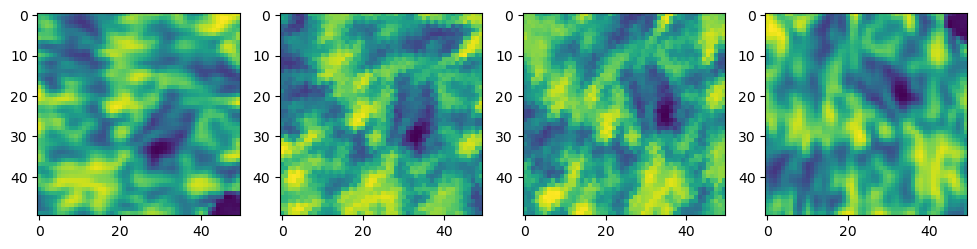

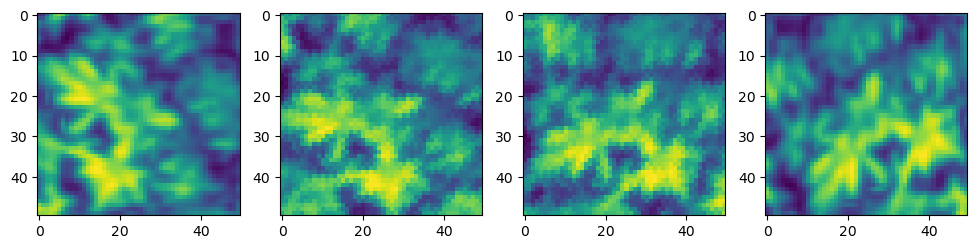

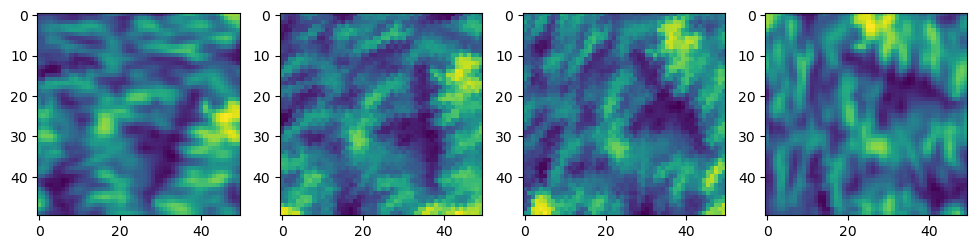

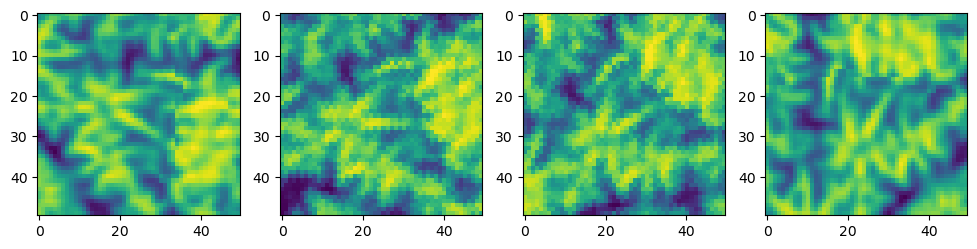

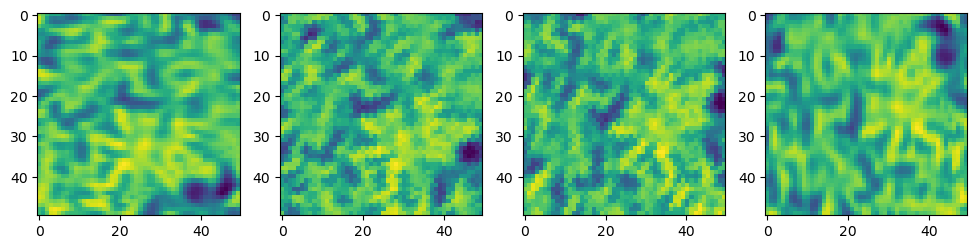

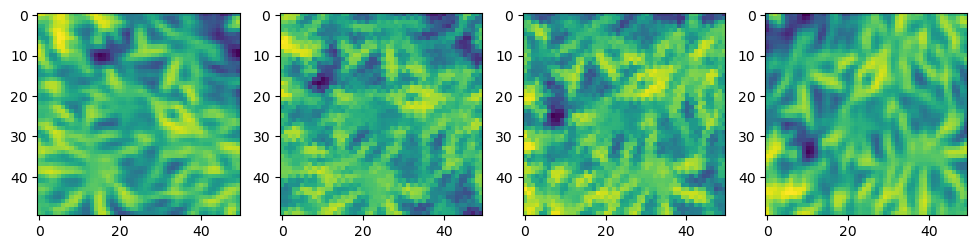

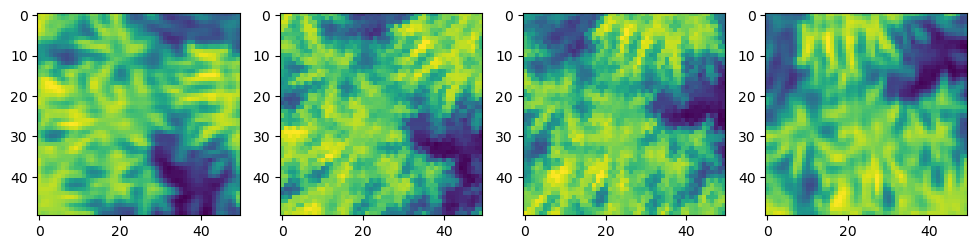

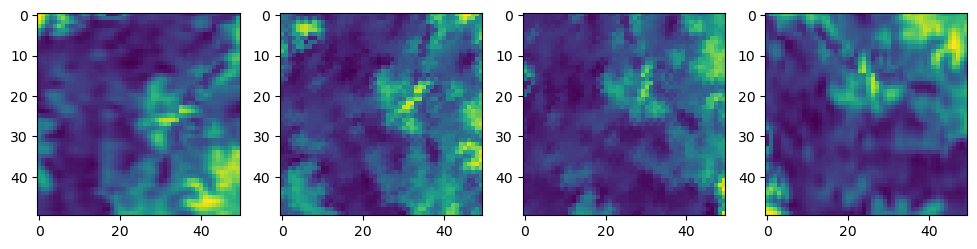

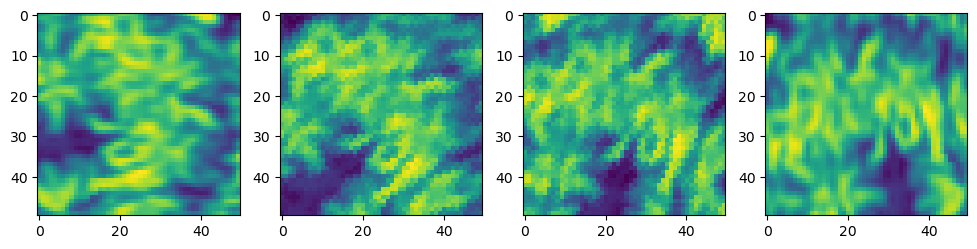

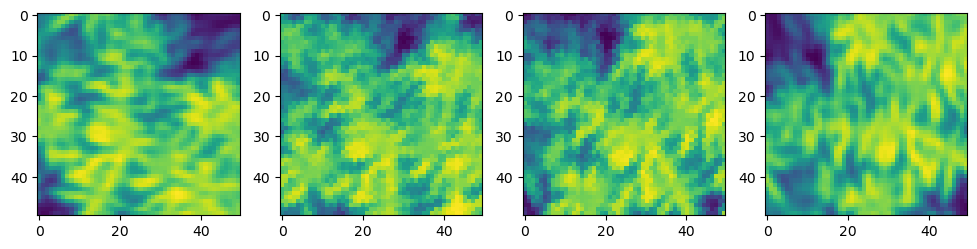

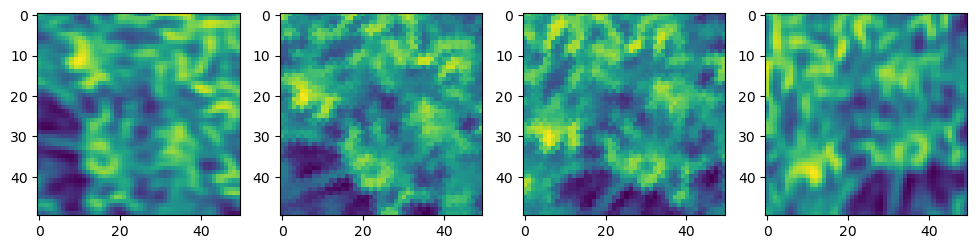

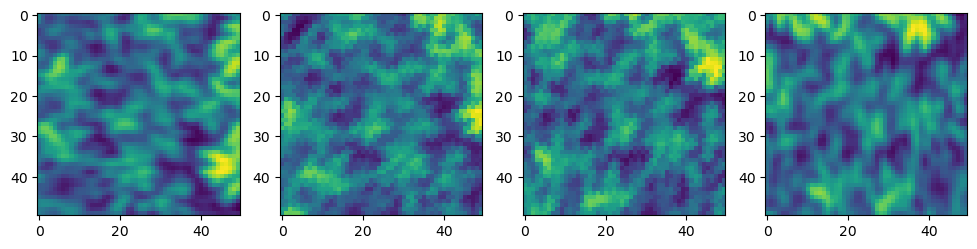

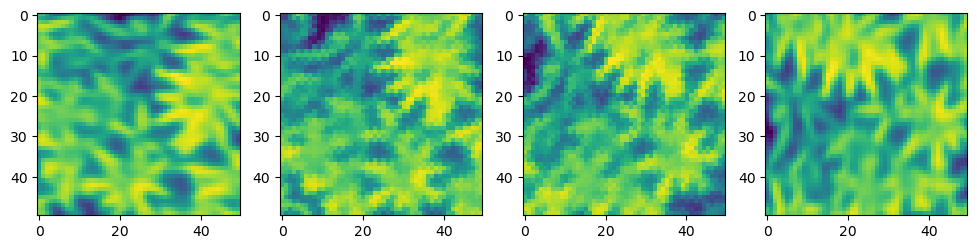

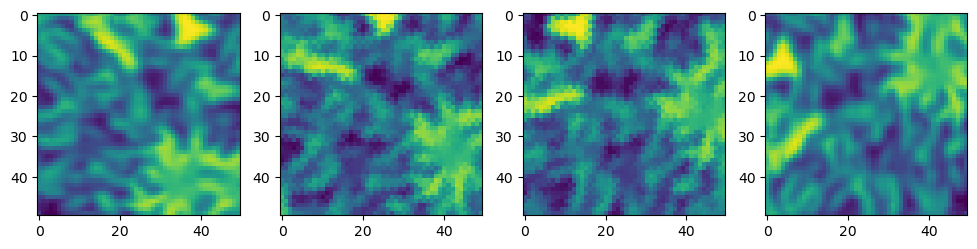

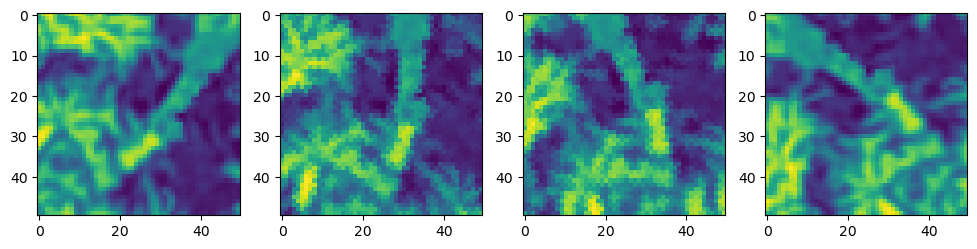

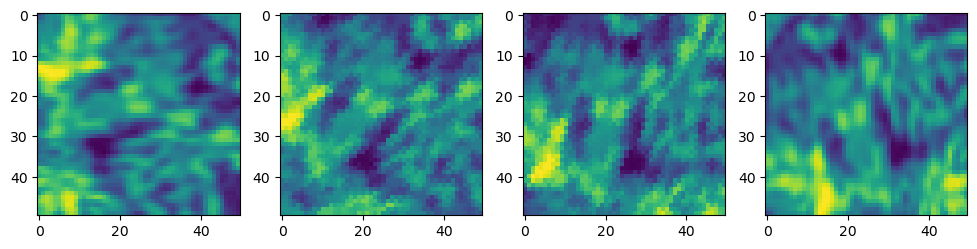

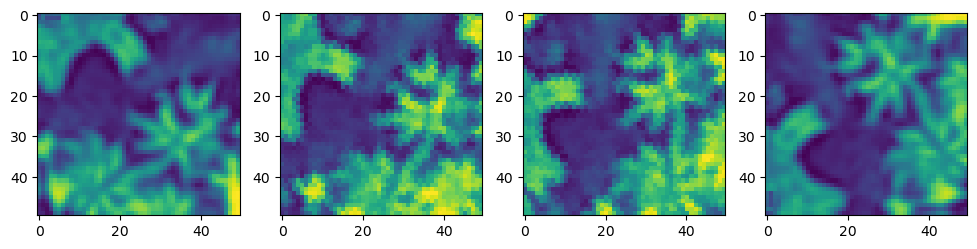

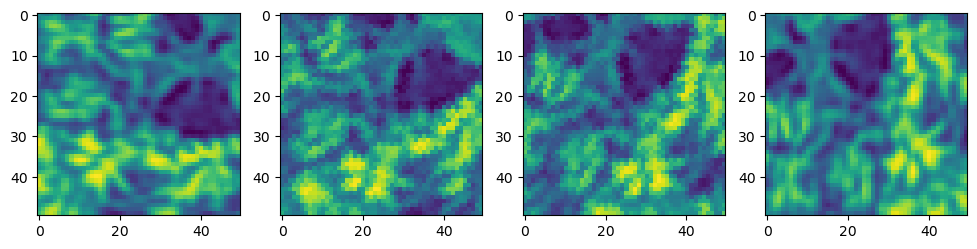

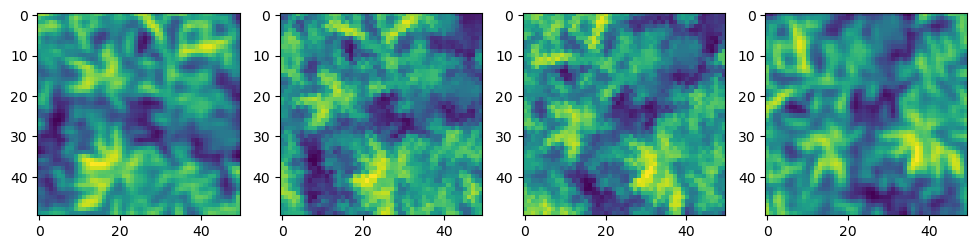

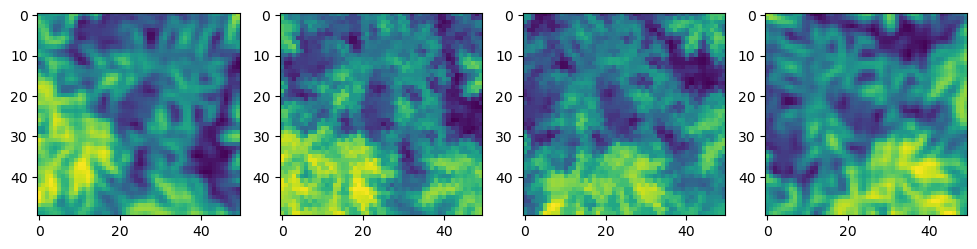

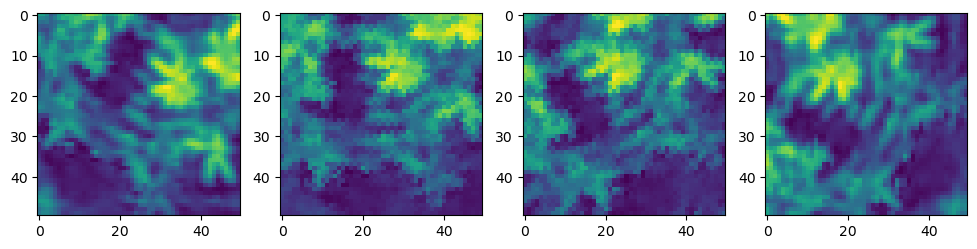

In [9]:
# Match the image to the template

listaresultados = []

templateBandList = []
for rowCol in surveyRowCol:
    imageList = []
    row = rowCol[0]
    col = rowCol[1]
    #append original band
    imageList.append(greenBand[row-radio:row+radio, col-radio:col+radio])
    #append rotated images
    templateBandToRotate = greenBand[row-2*radio:row+2*radio, col-2*radio:col+2*radio]
    rotationList = [i*30 for i in range(1,4)]
    for rotation in rotationList:
        rotatedRaw = Image.fromarray(templateBandToRotate)
        rotatedImage = rotatedRaw.rotate(rotation)
        imageList.append(np.asarray(rotatedImage)[radio:-radio,radio:-radio])
    #plot original and rotated images
    fig, ax = plt.subplots(1, len(imageList),figsize=(12,12))
    for index, item in enumerate(imageList):
        ax[index].imshow(imageList[index])
    #add images to total list
    templateBandList+=imageList

In [12]:
# match the template image to the orthophoto
matchXYList = []
for index, templateband in enumerate(templateBandList):
    if index%10 == 0:
        print('Match template ongoing for figure Nº %d'%index)
    matchTemplate = match_template(greenBand, templateband, pad_input=True)
    matchTemplateFiltered = np.where(matchTemplate>np.quantile(matchTemplate,0.9996))
    for item in zip(matchTemplateFiltered[0],matchTemplateFiltered[1]):
        x, y = palmRaster.xy(item[0], item[1])
        matchXYList.append([x,y])


        
    

Match template ongoing for figure Nº 0


KeyboardInterrupt: 

<AxesSubplot:>

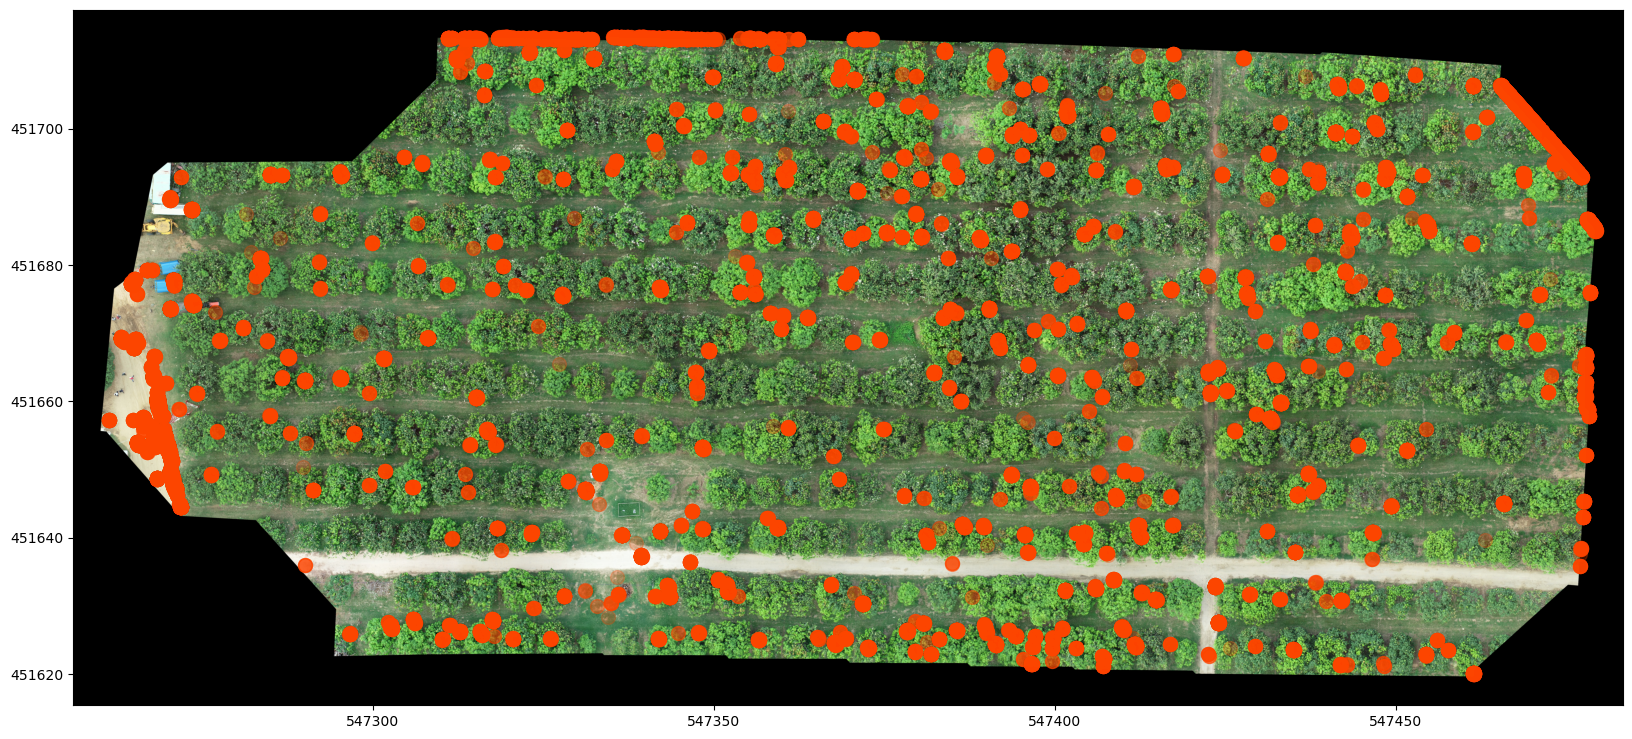

In [13]:
# plot interpreted points over the image
fig, ax = plt.subplots(figsize=(20, 20))
matchXYArray = np.array(matchXYList)
ax.scatter(matchXYArray[:,0],matchXYArray[:,1], marker='o',c='orangered', s=100, alpha=0.25)
show(palmRaster, ax=ax)

In [14]:
# cluster analysis
from sklearn.cluster import Birch
brc = Birch(branching_factor=10000, n_clusters=None, threshold=2e-5, compute_labels=True)
brc.fit(matchXYArray)
birchPoint = brc.subcluster_centers_
birchPoint

array([[547359.36050531, 451712.03715688],
       [547359.34500531, 451712.02165688],
       [547359.36825531, 451712.02165688],
       ...,
       [547461.42800531, 451620.02915688],
       [547461.38150531, 451620.01365688],
       [547461.41250531, 451620.01365688]])

C:\Users\Pc\anaconda3\lib\site-packages\rasterio\plot.py:112: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  arr = source.read(rgb_indexes, masked=True)


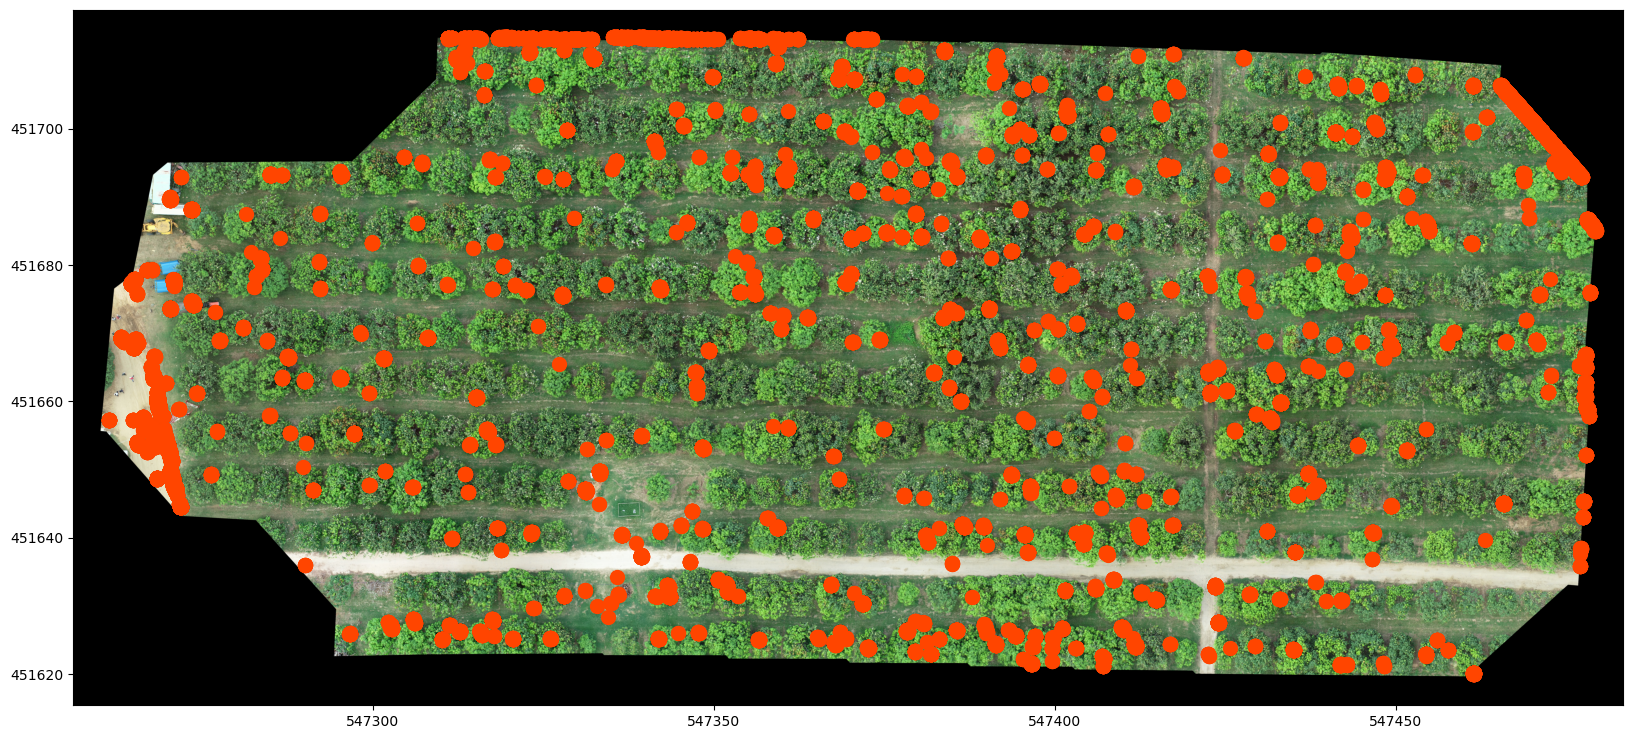

In [15]:
# plot clustered points
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.scatter(birchPoint[:,[0]],birchPoint[:,[1]], marker='o',color='orangered',s=100)
show(palmRaster, ax=ax)
plt.show()